Imports, run first!

In [1]:
#Data manipulation:

import numpy as np
import pandas as pd

#Plotting:

import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

#Machine learning:

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from generate_dataset import dat_to_df

#Misc:

from tqdm import tqdm


A collection of methods, run second. Consider putting these into separate files.


In [79]:
# Method for scaling every column in a dataframe, returns a copy of the dataframe with all variables scaled.
def scale_all(df:pd.DataFrame) -> pd.DataFrame:
    scaler = StandardScaler() 
    df_temp = df.copy(deep=True)
    for col in df.columns:
        df_temp[col] = scaler.fit_transform(df[[col]])

    return df_temp 

# Takes a dataframe, x, y, z variables(as specific columns in that dataframe), and a title string and produces a 3d scatter plot. 
# The name of the dataframe columns will be used as axis names.
def scatter_3d(df,x,y,z,title):
    fig = px.scatter_3d(df, 
                    x=x, 
                    y=y, 
                    z=z, 
                    opacity=0.8, color_discrete_sequence=[z],
                    height=1000, width=1000
                   )

    # Set figure title
    fig.update_layout(title_text=title,
                    scene_camera_eye=dict(x=1.5, y=1.5, z=0.25), 
                    scene_camera_center=dict(x=0, y=0, z=-0.2),
                    scene = dict(xaxis=dict(backgroundcolor='white',
                                            color='black',
                                            gridcolor='lightgrey'),
                                yaxis=dict(backgroundcolor='white',
                                            color='black',
                                            gridcolor='lightgrey'
                                            ),
                                zaxis=dict(backgroundcolor='white',
                                            color='black', 
                                            gridcolor='lightgrey')))

    # Update marker size
    fig.update_traces(marker=dict(size=2))

    fig.show()

# Takes a dataframe, x, y, z variables(as specific columns in that dataframe), a pre trained model(obviously trained on the same data),
# and a title string and produces a 3d scatter plot. The name of the dataframe columns will be used as axis names.
def scatter_w_pred(df,x,y,z,model,title):

    fig = px.scatter_3d(df, 
                    x=x, 
                    y=y, 
                    z=z, 
                    opacity=0.8, color_discrete_sequence=['black'],
                    height=1000, width=1000
                   )

    # Set figure title
    fig.update_layout(title_text=title,
                    scene_camera_eye=dict(x=1.5, y=1.5, z=0.25), 
                    scene_camera_center=dict(x=0, y=0, z=-0.2),
                    scene = dict(xaxis=dict(backgroundcolor='white',
                                            color='black',
                                            gridcolor='lightgrey'),
                                yaxis=dict(backgroundcolor='white',
                                            color='black',
                                            gridcolor='lightgrey'
                                            ),
                                zaxis=dict(backgroundcolor='white',
                                            color='black', 
                                            gridcolor='lightgrey')))

    # Update marker size
    fig.update_traces(marker=dict(size=2))

     # ----------- For creating a prediciton plane to be used in the visualization -----------
    # Set Increments between points in a meshgrid
    mesh_size = .1
    # Return evenly spaced values based on a range between min and max
    xrange = np.arange(x.min(), x.max(), mesh_size)
    yrange = np.arange(y.min(), y.max(), mesh_size)
    # Create a meshgrid
    xx, yy = np.meshgrid(xrange, yrange)
    # Make predictions
    pred = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Add prediction plane
    fig.add_traces(go.Surface(x=xrange, y=yrange, z=pred, name='prediction', 
                            colorscale=px.colors.sequential.Sunsetdark,opacity=.8,
                            showscale=False))

    fig.show()

   

    

Create all four dataframes from .dat files


In [2]:
df_SW = dat_to_df("small_wave/tec.dat","small_wave/mesh.dat")
df_LW = dat_to_df("large_wave/tec.dat","large_wave/mesh.dat")
df_OH = dat_to_df("one_hill/tec.dat","one_hill/mesh.dat")
df_TH = dat_to_df("two_hills/tec.dat","two_hills/mesh.dat")

Apply scaling to the dataframe, in this we create a scaled dataframe as a copy.

In [4]:
df_SW_scaled = scale_all(df_SW)
df_LW_scaled = scale_all(df_LW)
df_OH_scaled = scale_all(df_OH)
df_TH_scaled = scale_all(df_TH)

Correlation matrix for the different variables:

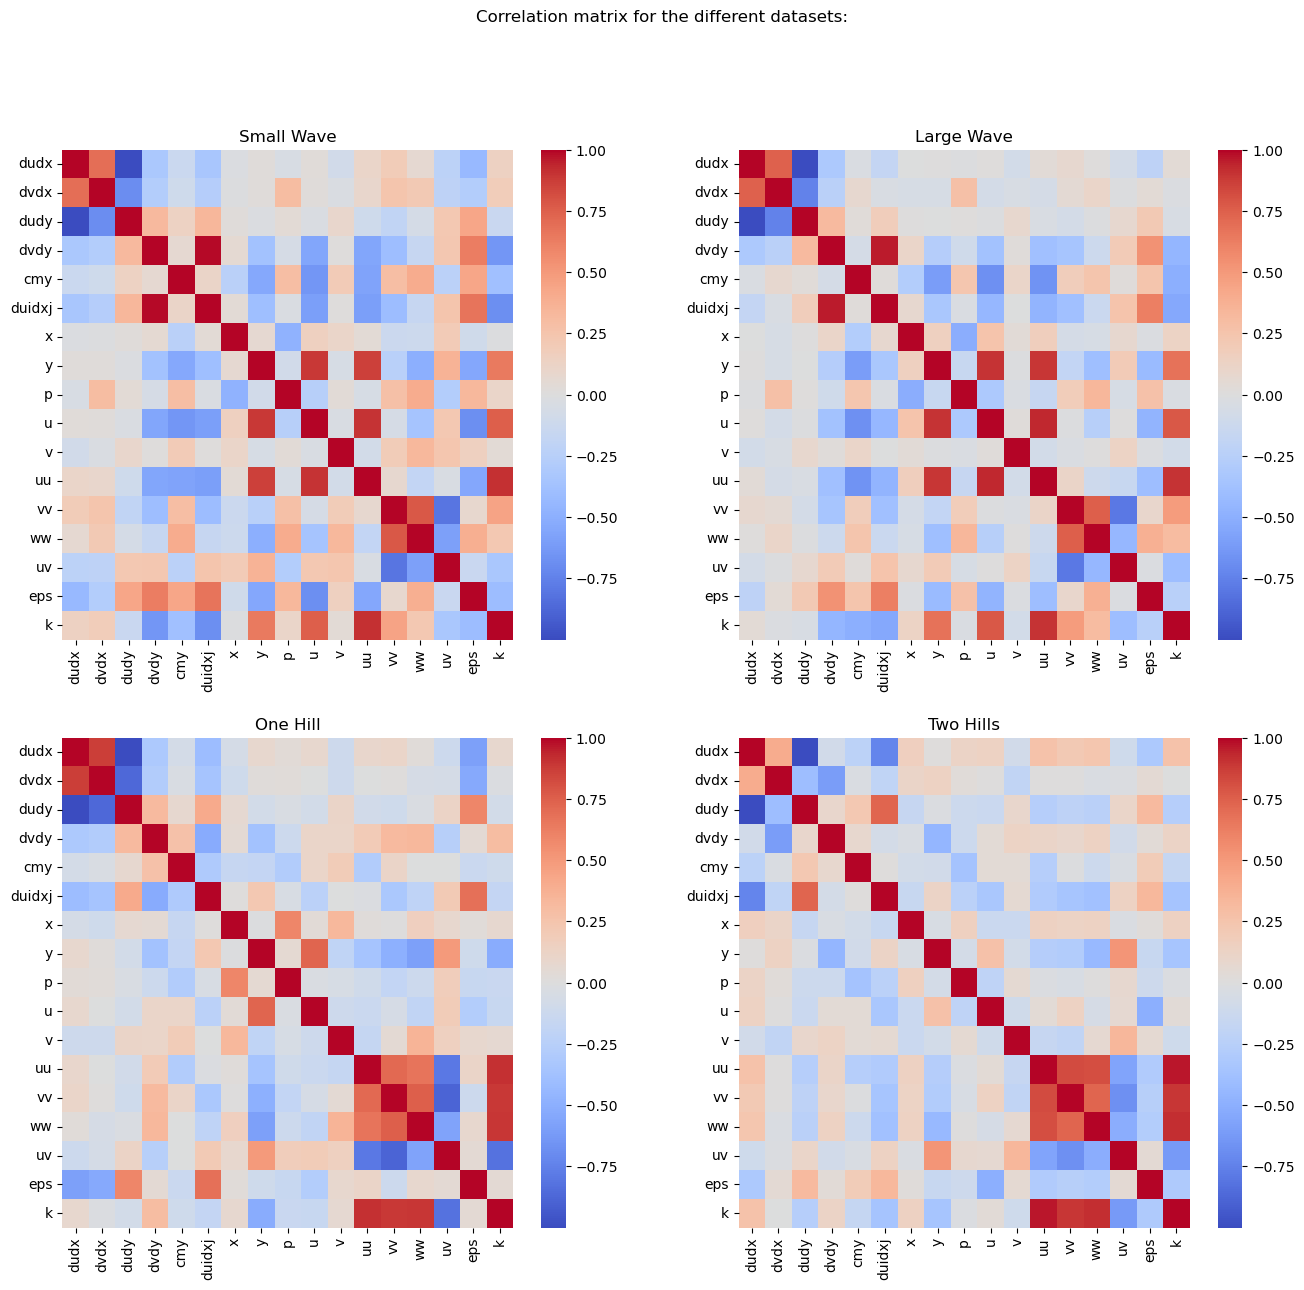

In [29]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16,14))
fig.suptitle('Correlation matrix for the different datasets:')
sns.heatmap(df_SW.corr(), cmap='coolwarm',ax=ax1).set(title='Small Wave')
sns.heatmap(df_LW.corr(), cmap='coolwarm',ax=ax2).set(title='Large Wave')
sns.heatmap(df_OH.corr(), cmap='coolwarm',ax=ax3).set(title='One Hill')
sns.heatmap(df_TH.corr(), cmap='coolwarm',ax=ax4).set(title='Two Hills')
plt.show()


Set up the machine learning model, in this case we test it on df_SW:


In [6]:
#Set up input/output variable(s)
X=df_SW_scaled[['v','u']]
Y=df_SW['cmy'].values

#Split into trainig set and test set:
X_train_SW, X_test_SW, Y_train_SW, Y_test_SW = train_test_split(X, Y, test_size=0.2, random_state=42)

#Choose model and fit it:
model = SVR(kernel='rbf', C=6, epsilon=0.01)
svr_SW = model.fit(X_train_SW, Y_train_SW)

In [34]:
scatter_3d(df_SW,df_SW_scaled['x'],df_SW_scaled['y'],df_SW['duidxj'],"")

In [57]:
# Load, and scale dataframe
df_SW = dat_to_df("small_wave/tec.dat","small_wave/mesh.dat")
df_SW_scaled = scale_all(df_SW)

# Choose in/out variable(s)
X=df_SW_scaled[['v','u']]
Y=df_SW['cmy']

# Split into trainig set and test set:
X_train_SW, X_test_SW, Y_train_SW, Y_test_SW = train_test_split(X, Y, test_size=0.2, random_state=42)
X_test_SW = X_test_SW.reset_index()
Y_test_SW = Y_test_SW.reset_index()

# Choose model and fit it:
model = SVR(kernel='rbf', C=6, epsilon=0.01)
svr_SW = model.fit(X_train_SW, Y_train_SW)

In [59]:
X_test_SW


index         v         u
0     25534 -0.464392  0.850475
1     20072  0.576652  0.344777
2      7221 -0.240980 -0.322999
3     23890 -0.833494  0.373708
4     11398 -0.072599 -0.105384
...     ...       ...       ...
6447  26321 -0.048273  0.970941
6448  20693 -1.132324  0.114537
6449  27941  0.289476  1.099006
6450   4003 -0.056363 -0.762542
6451  10827  0.989890 -0.173715

[6452 rows x 3 columns]

In [60]:
Y_test_SW

index       cmy
0     25534  0.087638
1     20072  0.200865
2      7221  0.152191
3     23890  0.173935
4     11398  0.266804
...     ...       ...
6447  26321  0.061325
6448  20693  0.269902
6449  27941  0.034337
6450   4003  0.077905
6451  10827  0.636920

[6452 rows x 2 columns]

In [80]:
scatter_w_pred(df_SW, X_test_SW['v'], X_test_SW['u'], Y_test_SW['cmy'], svr_SW, "Scatter Plot with Prediction Surface")

c:\Users\Ole\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but SVR was fitted with feature names



Testing different values for C

In [10]:
mae = []    
eps_perc = []

c_range = np.linspace(0.01, 15, num=30)
eps = 0.01

for c in tqdm(c_range):
    
    varied_svr = SVR(kernel = 'rbf', C=c, epsilon = eps)
    varied_svr.fit(X_train_SW, Y_train_SW)
    
    test_mae = mean_absolute_error(Y_test_SW, varied_svr.predict(X_test_SW))
    mae.append(test_mae)
    
    perc_within_eps = 100*np.sum(abs(Y_test_SW-varied_svr.predict(X_test_SW)) <= eps) / len(Y_test_SW)
    eps_perc.append(perc_within_eps)

fig, ax1 = plt.subplots(figsize=(12,7))

color='green'
ax1.set_xlabel('C')
ax1.set_ylabel('% within Epsilon', color=color)
ax1.scatter(c_range, eps_perc, color=color)
ax1.tick_params(axis='y', labelcolor=color)

color='blue'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Test MAE', color=color)  # we already handled the x-label with ax1
ax2.scatter(c_range, mae, color=color)
ax2.tick_params(axis='y', labelcolor=color)


plt.show()

  0%|          | 0/30 [00:34<?, ?it/s]


KeyboardInterrupt: 

Scale the neccecary columns of all dataframes, the scaled columns are added to the original   
dataframe giving a new column 'var_scaled' in addition to the original column 'var' 

In [ ]:

def scale_df(df:pd.DataFrame) -> pd.DataFrame:
    scaler = StandardScaler() 

    df['duidxj_scaled'] = scaler.fit_transform(df[['duidxj']])
    df['k_scaled']      = scaler.fit_transform(df[['k']])
    df['uv_scaled']     = scaler.fit_transform(df[['uv']])
    df['eps_scaled']    = scaler.fit_transform(df[['eps']])
    df['p_scaled']      = scaler.fit_transform(df[['p']])
    df['vv_scaled']     = scaler.fit_transform(df[['vv']])
    df['uu_scaled']     = scaler.fit_transform(df[['uu']])
    
    return df